# Part 2. Practice

#### 1.	Given https://github.com/yutkin/Lenta.Ru-News-Dataset, perform EDA on it focusing on the following:
-	Provide descriptive statistics
-	Anomaly detection   

#### 2.	Given the same dataset,
-		extract the most syntactically weighted N-grams, omitting nonsense (‘казалось бы’, ‘возможно предположить’, etc). The main idea is to extract the most valuable data from the text.
-	Try different models for a topic extraction. Which one performs better? What metrics were used to evaluate the model?

#### Import libraries

In [58]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

import numpy as np
import pandas as pd

import re
import string
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

import gensim
import pyLDAvis
import pyLDAvis.gensim

import stop_words

from pymystem3 import Mystem

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

#### Load and prepare dataset

#### Source of data:
https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta/

In [2]:
%%time
data = pd.read_csv('train_data.csv')

Wall time: 14 s


In order to save time I chose four topics neither too large nor too small.

In [4]:
topics = ['Экономика', 'Спорт', 'Культура', 'Наука и техника']

In [5]:
data = data.loc[data['topic'].isin(topics)]

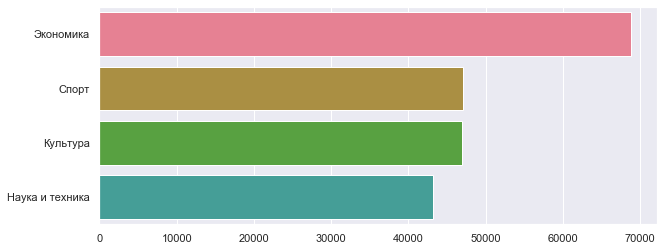

In [6]:
plt.figure(figsize=(10,4))
sns.barplot(x=data.topic.value_counts().values, y=data.topic.value_counts().index);

# The most syntactically weighted N-grams extracting

## Text preprocessing

### Lowercase Text

In [7]:
%%time
def lowercase_text(text):
    text = str(text).lower()
    return text


data['processed_text'] = data['text'].apply(
    lambda x: lowercase_text(x)
)
data['processed_text'].head(2)

Wall time: 12.5 s


536    с 1 января 2000 года все телеканалы будут опла...
541    германский автопромышленный концерн volkswagen...
Name: processed_text, dtype: object

### Removing Text Noise

In [8]:
%%time
def remove_noise(text):
    'Removing punctuation, html tags, symbols, numbers, etc.'
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub('\n', '', text)
    return text


data['processed_text'] = data['processed_text'].apply(
    lambda x: remove_noise(x)
)
data['processed_text'].head(2)

Wall time: 15.1 s


536    с  января  года все телеканалы будут оплачиват...
541    германский автопромышленный концерн volkswagen...
Name: processed_text, dtype: object

### Removing Stopwords

In [9]:
%%time
STOPWORDS = set(stop_words.get_stop_words('ru'))


def remove_stopwords(text, stopwords):
    token = [token for token in text.split() if token not in stopwords]
    return token
    
    
data['processed_text'] = data['processed_text'].apply(
    lambda x:  (remove_stopwords(x, STOPWORDS))
)
data['processed_text'].head(2)

Wall time: 8.63 s


536    [января, телеканалы, оплачивать, услуги, перед...
541    [германский, автопромышленный, концерн, volksw...
Name: processed_text, dtype: object

### Only keep the words that appear more than 20 times

In [10]:
%%time
def remove_outlier(texts):
    # Count word frequencies
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    result = [[token for token in text if frequency[token] > 20] for text in texts]
    return result


data['processed_text'] = remove_outlier(data['processed_text'])
data['processed_text'].head(2)

Wall time: 14.8 s


536    [января, телеканалы, оплачивать, услуги, перед...
541    [германский, концерн, volkswagen, намерен, пол...
Name: processed_text, dtype: object

### Lemmatization

In [11]:
# %%time
# mystem = Mystem()
# data['processed_text'] = data['processed_text'].apply(
#     lambda x:  mystem.lemmatize(x)
# )
# data['processed_text'].head(2)

### Stemming

In [12]:
%%time
stemmer = nltk.stem.snowball.RussianStemmer()


def stemming_seq(text, stemmer):
    result = []
    for token in text:
        result.append(stemmer.stem(token))
    return result
    
    
data['processed_text'] = data['processed_text'].apply(
    lambda x:  stemming_seq(x, stemmer)
)
data['processed_text'].head(2)

Wall time: 17min 17s


536    [январ, телеканал, оплачива, услуг, передач, е...
541    [германск, концерн, volkswagen, намер, полност...
Name: processed_text, dtype: object

# N-grams

In [13]:
N=20

In [14]:
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

#### Unigrams

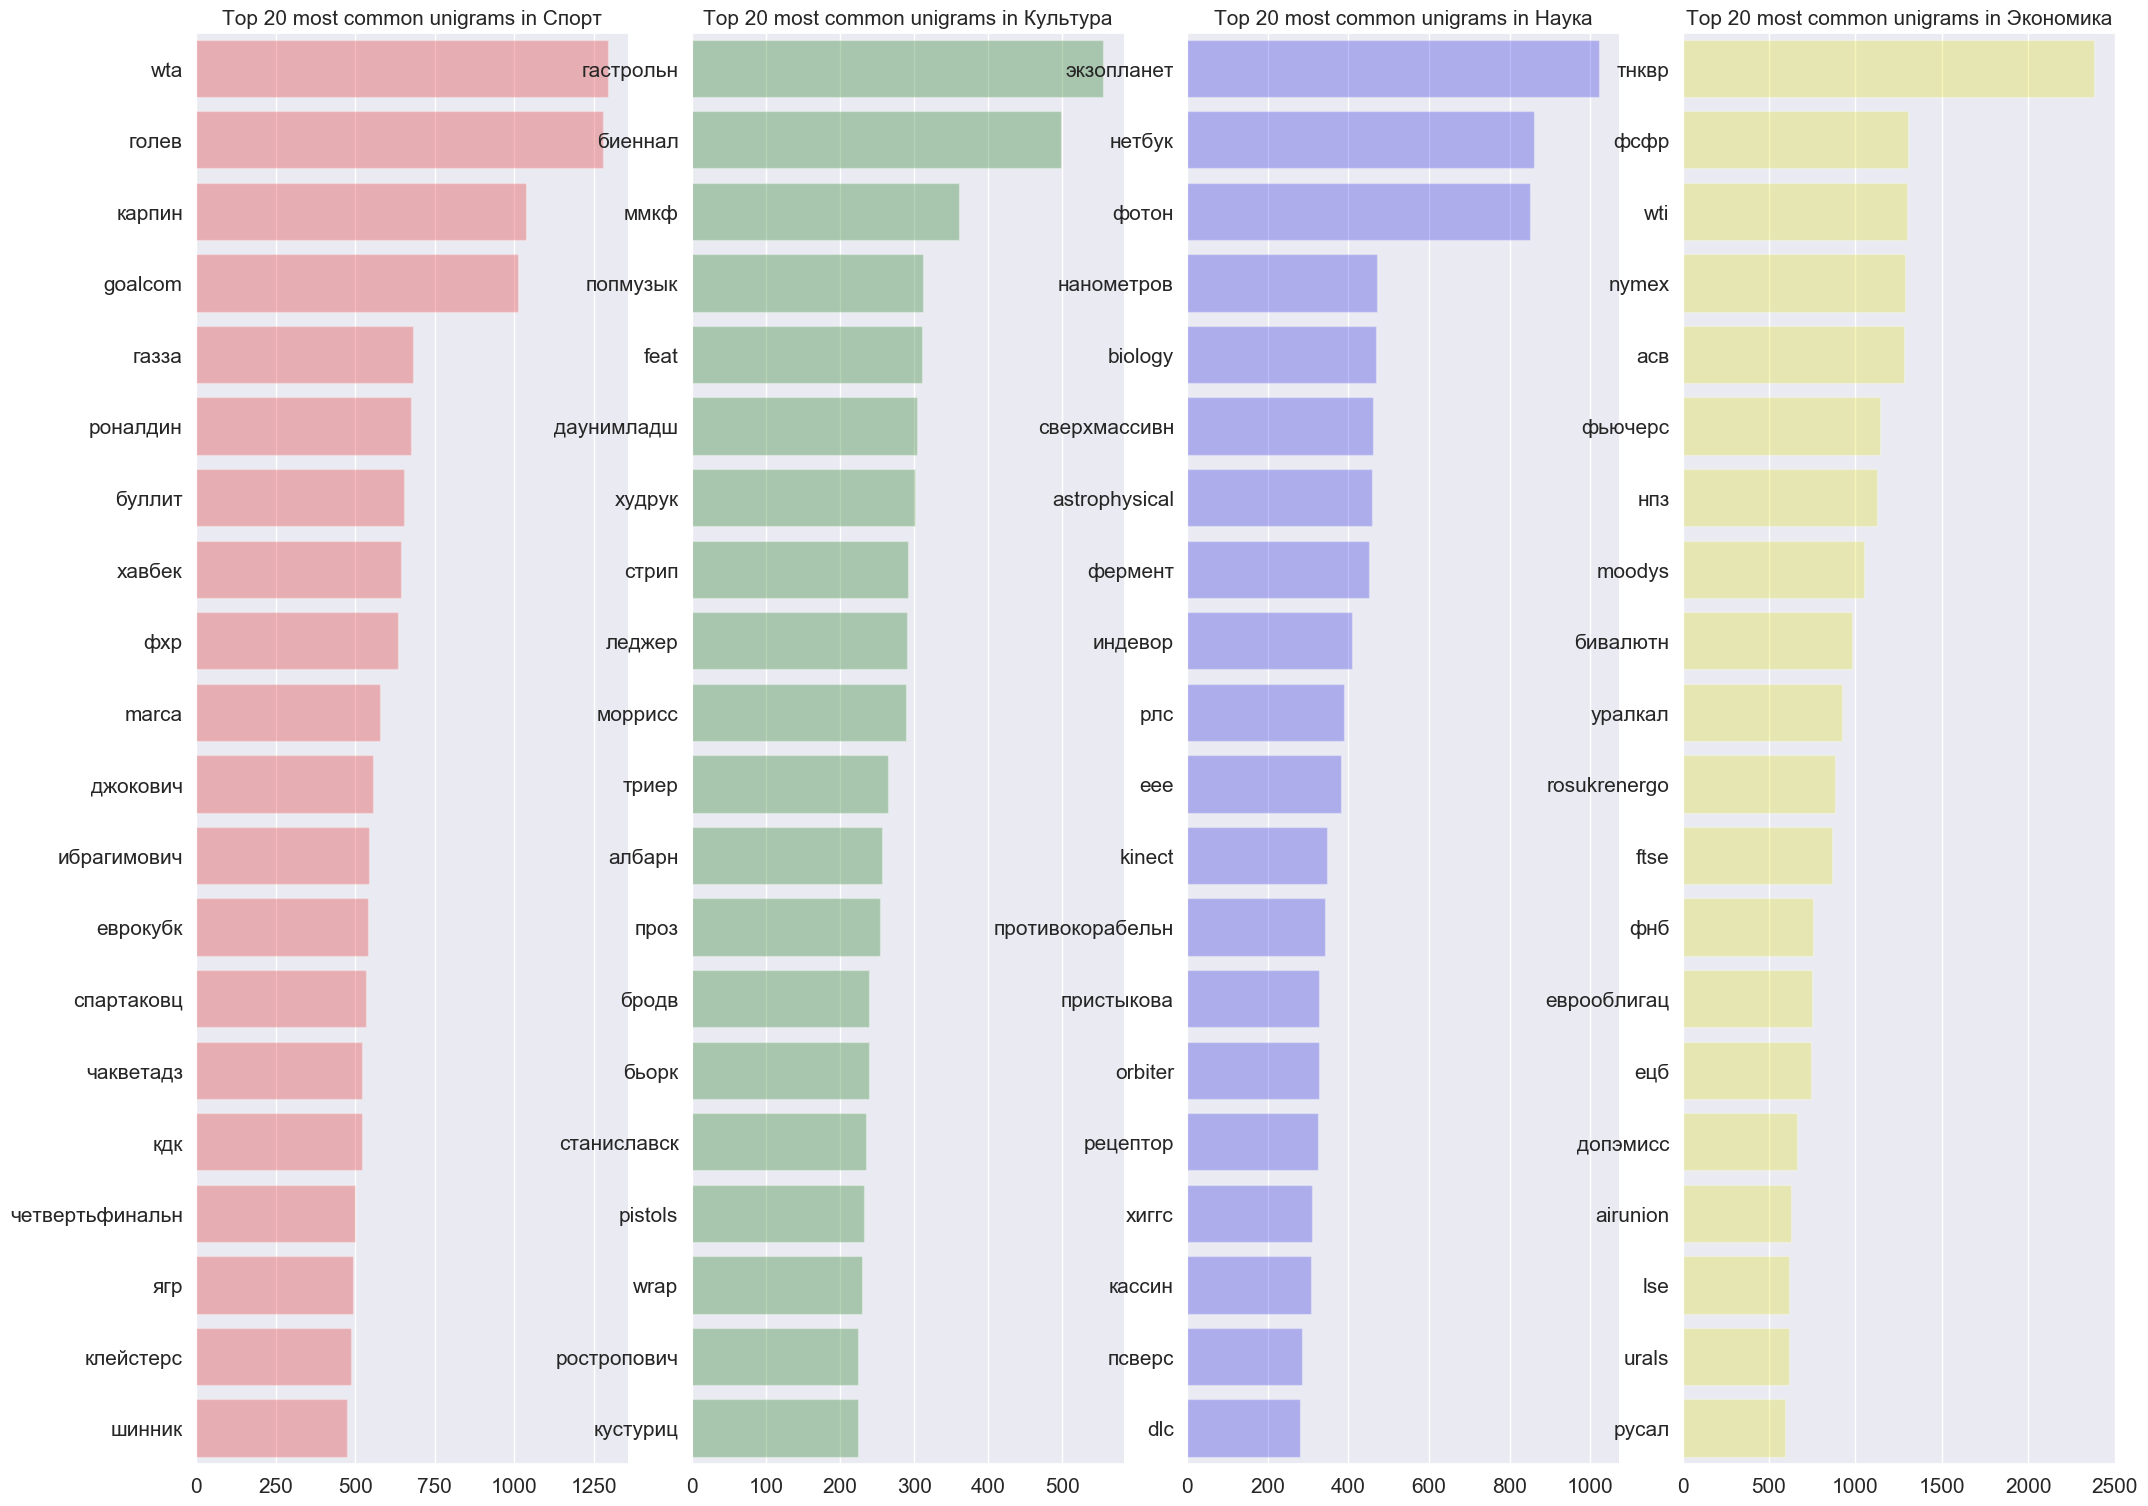

In [15]:
# unigrams on every topic and their frequencies
sport_unigrams = defaultdict(int)
culture_unigrams = defaultdict(int)
sci_unigrams = defaultdict(int)
economy_unigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text):
        sport_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text):        
        culture_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text):   
        sci_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Экономика', 'processed_text']:
    for word in generate_ngrams(text):   
        economy_unigrams[word] += 1

# sets of unigrams on every topic
sport_unigrams_keys = set(sport_unigrams.keys())
culture_unigrams_keys = set(culture_unigrams.keys())
sci_unigrams_keys = set(sci_unigrams.keys())
economy_unigrams_keys = set(economy_unigrams.keys())

# unique unigrams on every topic
unique_sport_unigrams = sport_unigrams_keys - culture_unigrams_keys - sci_unigrams_keys - economy_unigrams_keys
unique_sport_unigrams = {k : v for k, v in iter(sport_unigrams.items()) if k in unique_sport_unigrams}

unique_culture_unigrams = culture_unigrams_keys - sci_unigrams_keys - economy_unigrams_keys - sport_unigrams_keys
unique_culture_unigrams = {k : v for k, v in iter(culture_unigrams.items()) if k in unique_culture_unigrams}

unique_sci_unigrams = sci_unigrams_keys - economy_unigrams_keys - sport_unigrams_keys - culture_unigrams_keys
unique_sci_unigrams = {k : v for k, v in iter(sci_unigrams.items()) if k in unique_sci_unigrams}

unique_economy_unigrams = economy_unigrams_keys - sport_unigrams_keys - culture_unigrams_keys - sci_unigrams_keys
unique_economy_unigrams = {k : v for k, v in iter(economy_unigrams.items()) if k in unique_economy_unigrams}

# datasets with the unique unigrams and their frequencies
df_sport_unigrams = pd.DataFrame(sorted(unique_sport_unigrams.items(), key=lambda x: x[1])[::-1])
df_culture_unigrams = pd.DataFrame(sorted(unique_culture_unigrams.items(), key=lambda x: x[1])[::-1])
df_sci_unigrams = pd.DataFrame(sorted(unique_sci_unigrams.items(), key=lambda x: x[1])[::-1])
df_economy_unigrams = pd.DataFrame(sorted(unique_economy_unigrams.items(), key=lambda x: x[1])[::-1])

# 20 most popular unigrams per topic
fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_unigrams[0].values[:N], 
    x=df_sport_unigrams[1].values[:N], 
    ax=axes[0], 
    color='red', 
    alpha=0.3
)
sns.barplot(
    y=df_culture_unigrams[0].values[:N], 
    x=df_culture_unigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_unigrams[0].values[:N], 
    x=df_sci_unigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_economy_unigrams[0].values[:N], 
    x=df_economy_unigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common unigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common unigrams in Экономика', fontsize=15)

plt.show()

#### Bigrams

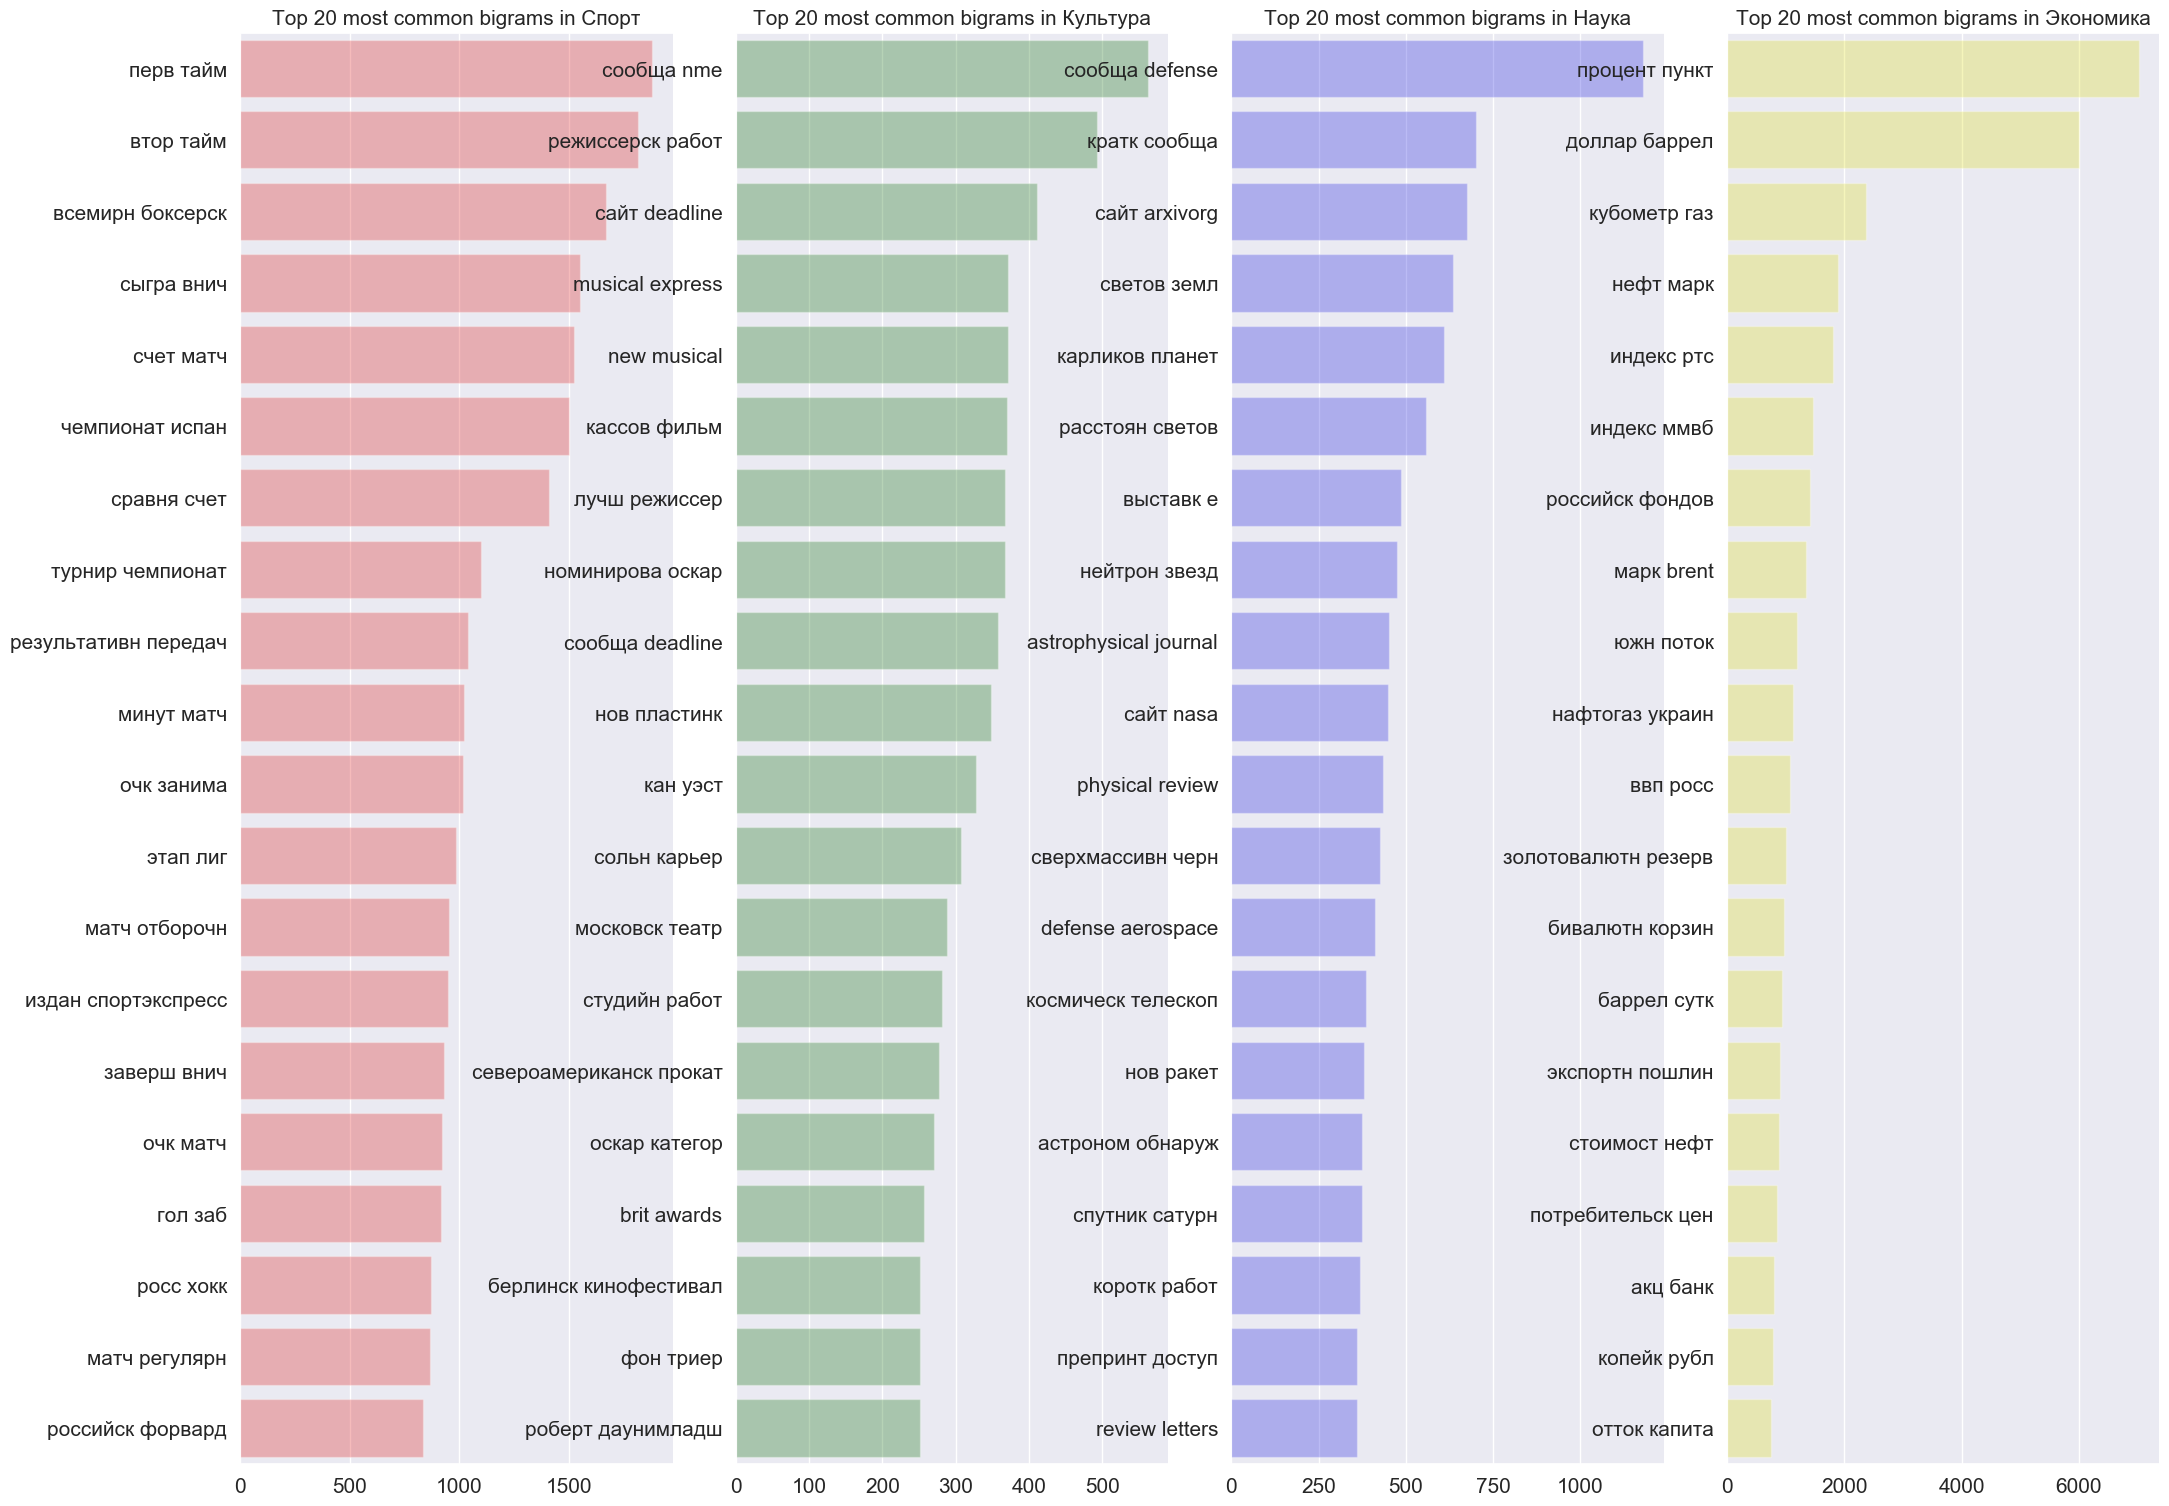

In [16]:
# Bigrams
sport_bigrams = defaultdict(int)
culture_bigrams = defaultdict(int)
sci_bigrams = defaultdict(int)
economy_bigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text, 2):
        sport_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text, 2):        
        culture_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text, 2):   
        sci_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Экономика', 'processed_text']:
    for word in generate_ngrams(text, 2):   
        economy_bigrams[word] += 1

sport_bigrams_keys = set(sport_bigrams.keys())
culture_bigrams_keys = set(culture_bigrams.keys())
sci_bigrams_keys = set(sci_bigrams.keys())
economy_bigrams_keys = set(economy_bigrams.keys())

unique_sport_bigrams = sport_bigrams_keys - culture_bigrams_keys - sci_bigrams_keys - economy_bigrams_keys
unique_sport_bigrams = {k : v for k, v in iter(sport_bigrams.items()) if k in unique_sport_bigrams}

unique_culture_bigrams = culture_bigrams_keys - sci_bigrams_keys - economy_bigrams_keys - sport_bigrams_keys
unique_culture_bigrams = {k : v for k, v in iter(culture_bigrams.items()) if k in unique_culture_bigrams}

unique_sci_bigrams = sci_bigrams_keys - economy_bigrams_keys - sport_bigrams_keys - culture_bigrams_keys
unique_sci_bigrams = {k : v for k, v in iter(sci_bigrams.items()) if k in unique_sci_bigrams}

unique_economy_bigrams = economy_bigrams_keys - sport_bigrams_keys - culture_bigrams_keys - sci_bigrams_keys
unique_economy_bigrams = {k : v for k, v in iter(economy_bigrams.items()) if k in unique_economy_bigrams}

df_sport_bigrams = pd.DataFrame(sorted(unique_sport_bigrams.items(), key=lambda x: x[1])[::-1])
df_culture_bigrams = pd.DataFrame(sorted(unique_culture_bigrams.items(), key=lambda x: x[1])[::-1])
df_sci_bigrams = pd.DataFrame(sorted(unique_sci_bigrams.items(), key=lambda x: x[1])[::-1])
df_economy_bigrams = pd.DataFrame(sorted(unique_economy_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_bigrams[0].values[:N], 
    x=df_sport_bigrams[1].values[:N], 
    ax=axes[0], 
    color='red',
    alpha=0.3
)
sns.barplot(
    y=df_culture_bigrams[0].values[:N], 
    x=df_culture_bigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_bigrams[0].values[:N], 
    x=df_sci_bigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_economy_bigrams[0].values[:N], 
    x=df_economy_bigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common bigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common bigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common bigrams in Экономика', fontsize=15)

plt.show()

#### Trigrams

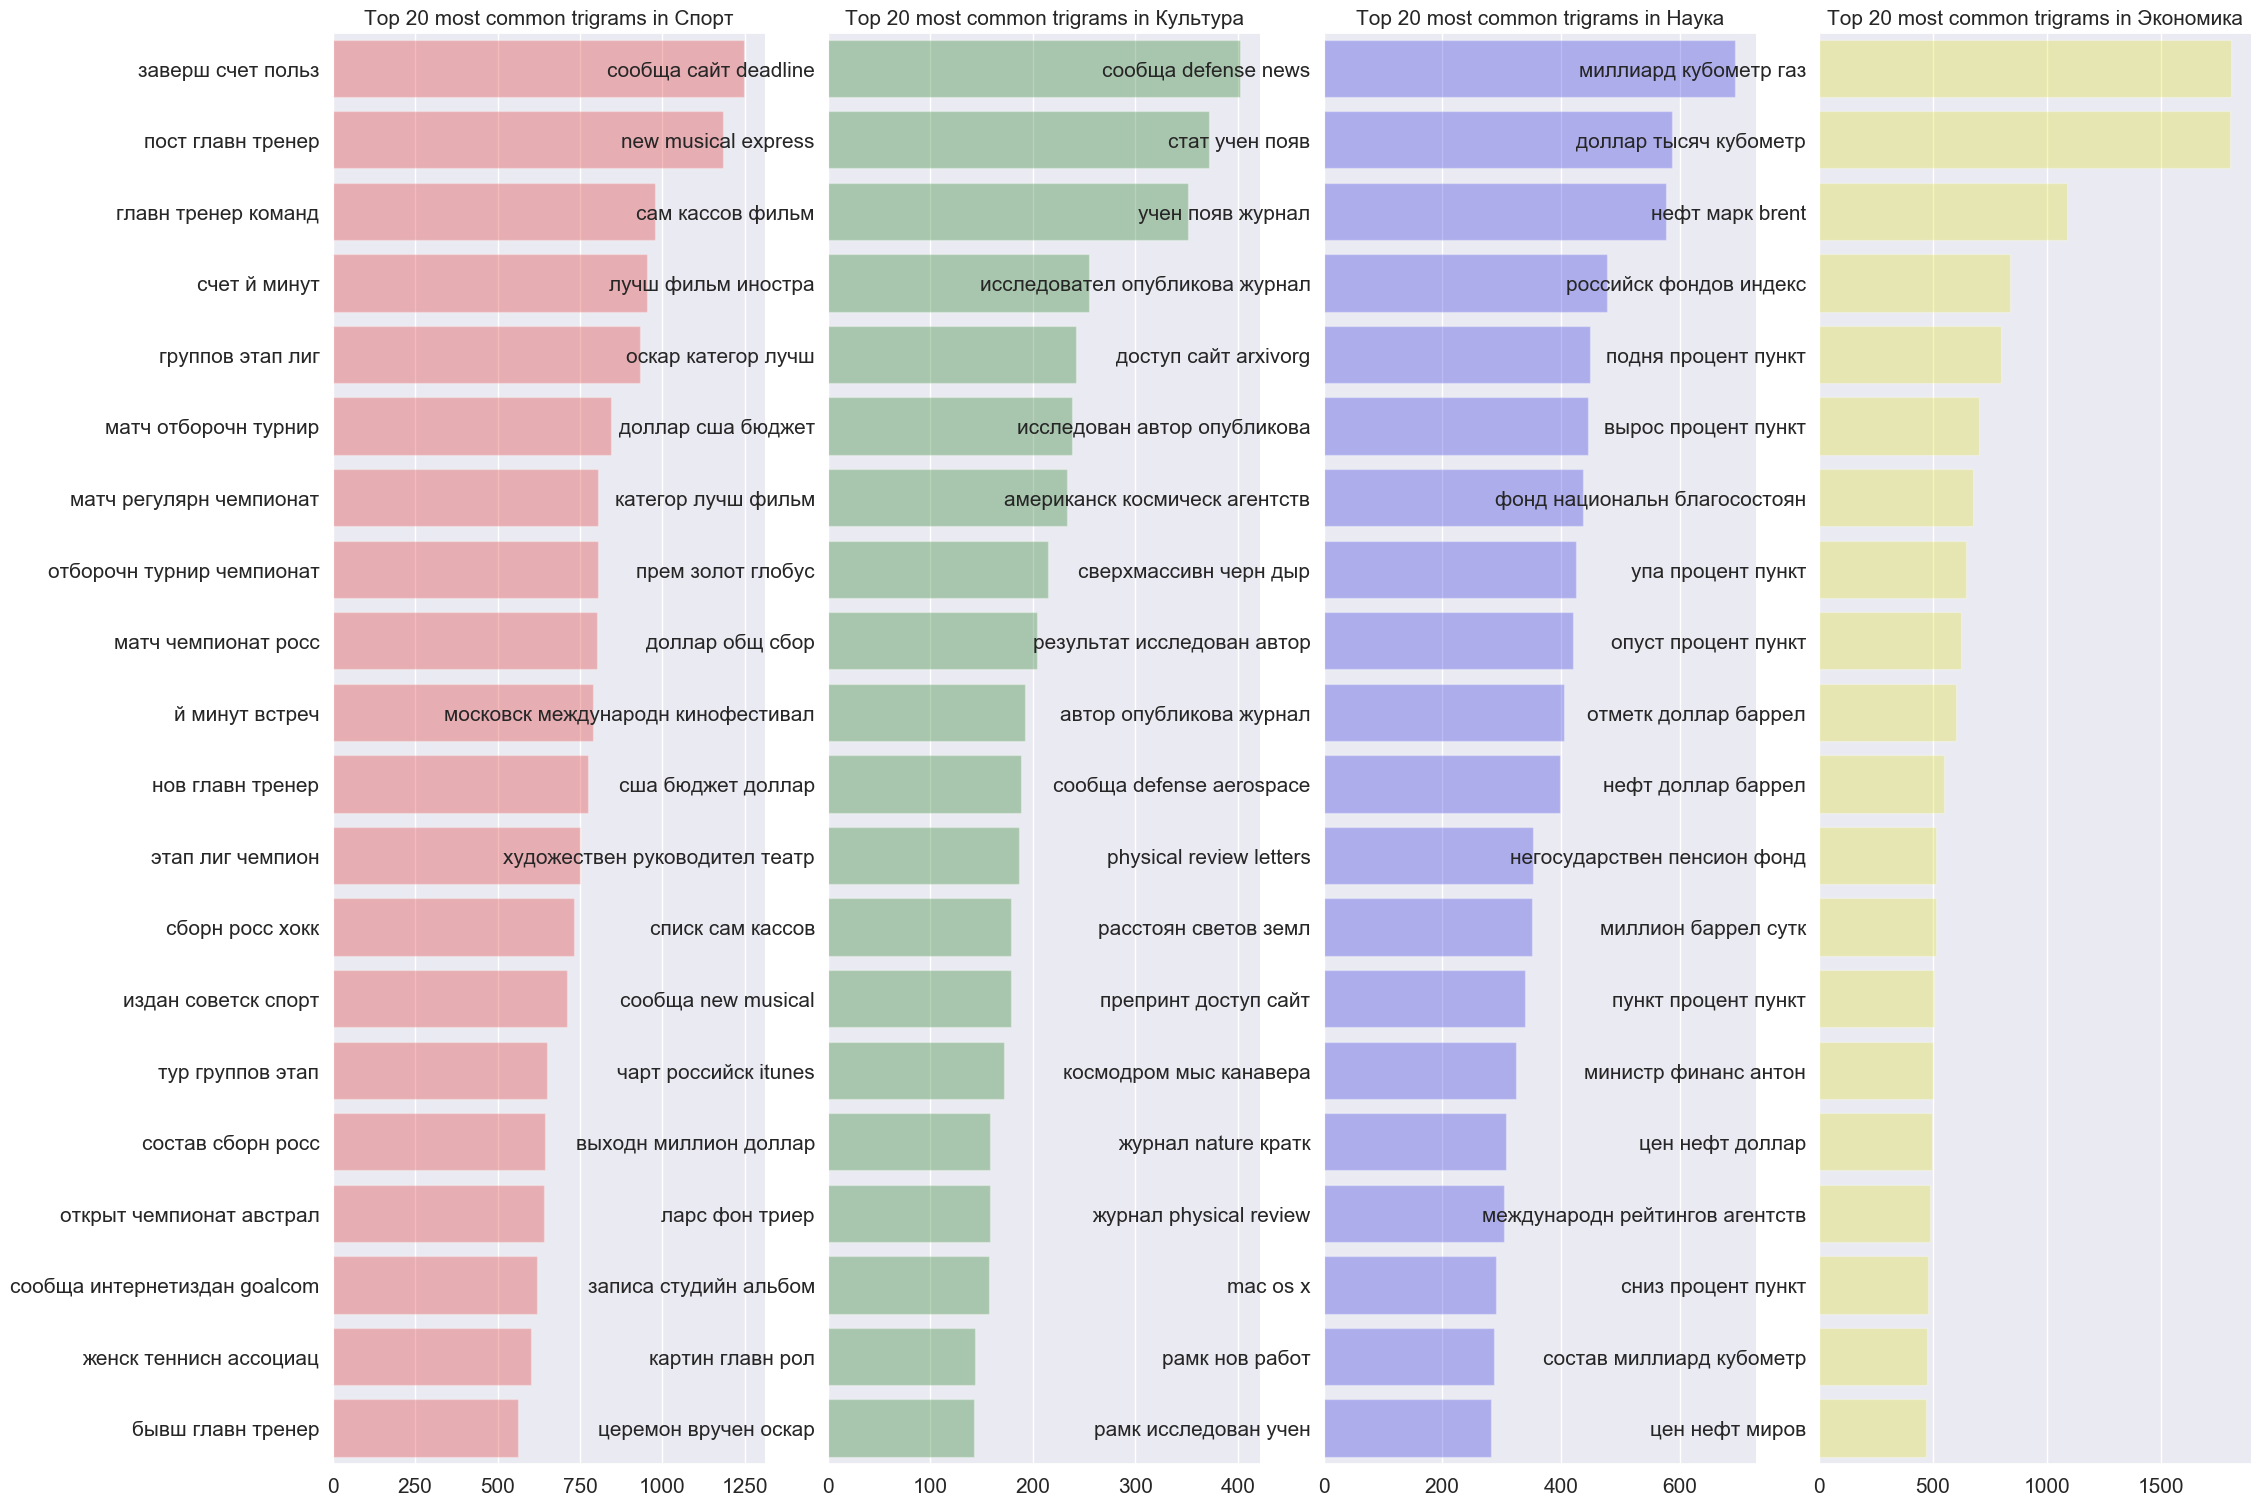

In [17]:
# Trigrams
sport_trigrams = defaultdict(int)
culture_trigrams = defaultdict(int)
sci_trigrams = defaultdict(int)
economy_trigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text, 3):
        sport_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text, 3):        
        culture_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text, 3):   
        sci_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Экономика', 'processed_text']:
    for word in generate_ngrams(text, 3):   
        economy_trigrams[word] += 1

sport_trigrams_keys = set(sport_trigrams.keys())
culture_trigrams_keys = set(culture_trigrams.keys())
sci_trigrams_keys = set(sci_trigrams.keys())
economy_trigrams_keys = set(economy_trigrams.keys())

unique_sport_trigrams = sport_trigrams_keys - culture_trigrams_keys - sci_trigrams_keys - economy_trigrams_keys
unique_sport_trigrams = {k : v for k, v in iter(sport_trigrams.items()) if k in unique_sport_trigrams}

unique_culture_trigrams = culture_trigrams_keys - sci_trigrams_keys - economy_trigrams_keys - sport_trigrams_keys
unique_culture_trigrams = {k : v for k, v in iter(culture_trigrams.items()) if k in unique_culture_trigrams}

unique_sci_trigrams = sci_trigrams_keys - economy_trigrams_keys - sport_trigrams_keys - culture_trigrams_keys
unique_sci_trigrams = {k : v for k, v in iter(sci_trigrams.items()) if k in unique_sci_trigrams}

unique_economy_trigrams = economy_trigrams_keys - sport_trigrams_keys - culture_trigrams_keys - sci_trigrams_keys
unique_economy_trigrams = {k : v for k, v in iter(economy_trigrams.items()) if k in unique_economy_trigrams}

df_sport_trigrams = pd.DataFrame(sorted(unique_sport_trigrams.items(), key=lambda x: x[1])[::-1])
df_culture_trigrams = pd.DataFrame(sorted(unique_culture_trigrams.items(), key=lambda x: x[1])[::-1])
df_sci_trigrams = pd.DataFrame(sorted(unique_sci_trigrams.items(), key=lambda x: x[1])[::-1])
df_economy_trigrams = pd.DataFrame(sorted(unique_economy_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_trigrams[0].values[:N], 
    x=df_sport_trigrams[1].values[:N], 
    ax=axes[0], 
    color='red', 
    alpha=0.3
)
sns.barplot(
    y=df_culture_trigrams[0].values[:N], 
    x=df_culture_trigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_trigrams[0].values[:N], 
    x=df_sci_trigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_economy_trigrams[0].values[:N], 
    x=df_economy_trigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common trigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common trigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common trigrams in Экономика', fontsize=15)

plt.show()

## N-grams using NLTK

In [18]:
%%time
data['bigrams'] = data['processed_text'].apply(lambda x: list(ngrams(x, 2)))
data['bigrams'].head()

Wall time: 37.2 s


536    [(январ, телеканал), (телеканал, оплачива), (о...
541    [(германск, концерн), (концерн, volkswagen), (...
542    [(прибыл, оа), (оа, дочерн), (дочерн, предприя...
564    [(крупн, телекоммуникацион), (телекоммуникацио...
565    [(оа, газ), (газ, нижегородск), (нижегородск, ...
Name: bigrams, dtype: object

In [19]:
data['trigrams'] = data['processed_text'].apply(lambda x: list(ngrams(x, 3)))
data['trigrams'].head()

536    [(январ, телеканал, оплачива), (телеканал, опл...
541    [(германск, концерн, volkswagen), (концерн, vo...
542    [(прибыл, оа, дочерн), (оа, дочерн, предприят)...
564    [(крупн, телекоммуникацион, компан), (телекомм...
565    [(оа, газ, нижегородск), (газ, нижегородск, ба...
Name: trigrams, dtype: object

# Topic extraction with Tensorflow

In [20]:
topics = data['topic'].unique()
topics

array(['Экономика', 'Спорт', 'Культура', 'Наука и техника'], dtype=object)

In [21]:
replace_dict = {topics[i]: i for i in range(len(topics))}  # topics' names to numbers dict

data['topic'].replace(replace_dict, inplace=True)  # changing names for numbers

#### Training and validating datasets

In [22]:
X = data['processed_text']
y = data['topic'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

X_train.shape, len(y_train)

((137995,), 137995)

In [23]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [24]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

#### Pre-Processing

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  
word_index = tokenizer.word_index
print(len(word_index))

31811


In [27]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, padding='post')
print(X_train[0])
print(X_train.shape)

[ 1137 18061  2031   305   108   334  1526    42  5354   200   502   338
  2412 18707 18061   269     9    29  1039   266  1613  2077 15029   289
    55   139   735 22107  1392   882 18061   735  1861  1039  1225  1230
     3   108    29   269  2621  8201   725 18061   735    45     6  8201
   449     9   876   120    55   106  7479   289  2469   269    29  2514
 23713    35   229  3039 13080   269    29  2374 16371   289   229    55
 18061    19    42 18707   305  5719 27282    67    29   269 22107   143
  2412  8201   725  1024   412  1039     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [28]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post')

In [29]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

In [30]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

#### Building the model

In [31]:
vocab_size = len(word_index)
embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          2035968   
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 2,038,180
Trainable params: 2,038,180
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time
num_epochs = 5
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=test_dataset)

Epoch 1/5
2157/2157 [==============================] - 77s 36ms/step - loss: 0.1979 - accuracy: 0.9331 - val_loss: 0.0571 - val_accuracy: 0.9818
Epoch 2/5
2157/2157 [==============================] - 72s 33ms/step - loss: 0.0412 - accuracy: 0.9868 - val_loss: 0.0486 - val_accuracy: 0.9841
Epoch 3/5
2157/2157 [==============================] - 71s 33ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0484 - val_accuracy: 0.9840
Epoch 4/5
2157/2157 [==============================] - 70s 33ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.0522 - val_accuracy: 0.9833
Epoch 5/5
2157/2157 [==============================] - 71s 33ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0538 - val_accuracy: 0.9840
Wall time: 6min 6s


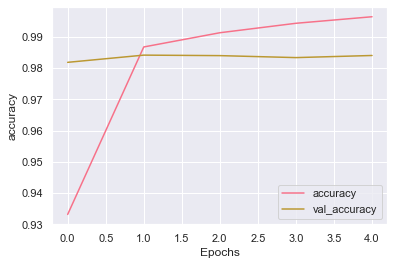

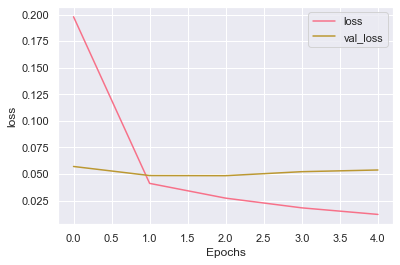

In [33]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "accuracy")  # Plot training and validation accuracy per epoch
plot_graphs(history, "loss")  # Plot training and validation loss per epoch

As you can see, the elementary model shows a very good result.

I believe that Logistic Regression should successfully handle this task.

# Topic extraction with Gensim

In [34]:
docs = X.tolist()

In [35]:
len(docs)

205964

#### Compute bigrams

In [36]:
from gensim.models import Phrases
bigram = Phrases(docs, min_count=20)

In [37]:
# Add bigrams to docs (only ones that appear 20 times or more).
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

#### Remove rare and common tokens

In [38]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
len(dictionary)

In [40]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
len(dictionary)

55677

#### Bag-of-words representation of the documents

In [41]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

#### Train LDA model

In [42]:
%%time
from gensim.models import LdaModel

# Set training parameters.
num_topics = 4
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

Wall time: 25min 54s


In [55]:
model.print_topics()

[(0,
  '0.012*"компан" + 0.006*"российск" + 0.005*"проект" + 0.005*"росс" + 0.004*"нов" + 0.004*"газ" + 0.004*"суд" + 0.004*"космическ" + 0.003*"ракет" + 0.003*"сша"'),
 (1,
  '0.015*"матч" + 0.011*"команд" + 0.011*"сборн" + 0.011*"клуб" + 0.010*"чемпионат" + 0.009*"росс" + 0.008*"футболист" + 0.006*"счет" + 0.005*"футбольн" + 0.005*"футбол"'),
 (2,
  '0.014*"росс" + 0.009*"рубл" + 0.008*"доллар" + 0.008*"миллиард" + 0.008*"процент" + 0.006*"стран" + 0.006*"российск" + 0.005*"заяв" + 0.005*"банк" + 0.005*"цен"'),
 (3,
  '0.007*"фильм" + 0.006*"учен" + 0.003*"нов" + 0.003*"групп" + 0.003*"актер" + 0.003*"опубликова" + 0.003*"the" + 0.003*"картин" + 0.003*"рол" + 0.003*"исследован"')]

As you can see the model successfully extracted the topics from the corpus that correlate with the target topics.

In [61]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.009274 -0.221781       1        1  31.151056
2     -0.140406  0.115269       2        1  28.716990
0     -0.129073  0.024336       3        1  21.455965
1      0.260205  0.082175       4        1  18.675991, topic_info=          Term           Freq          Total Category  logprob  loglift
9236      матч   72892.000000   72892.000000  Default  30.0000  30.0000
9243     сборн   53509.000000   53509.000000  Default  29.0000  29.0000
4210    команд   57952.000000   57952.000000  Default  28.0000  28.0000
925       клуб   51487.000000   51487.000000  Default  27.0000  27.0000
70      компан  105699.000000  105699.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
5812       игр   17420.402344   28294.494141   Topic4  -5.6306   1.1929
184       мест   19000.003906   39398.382812   Topic4  -5.5438   0.9486
1655      летн   16755.183594   28167.138672   Topic4  -5.6695   1.1585
23    российск   22590.931641  112296.648438   Topic4  -5.3707   0.0743
136     состав   15599.745117   51236.828125   Topic4  -5.7410   0.4887

[280 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
23473      3  0.999795       apple
17446      3  0.999784      falcon
42613      3  0.999888      spacex
1960       1  0.841791         the
1960       2  0.063638         the
...      ...       ...         ...
1799       3  0.999701  эксплуатац
39         1  0.379592        явля
39         2  0.265039        явля
39         3  0.242240        явля
39         4  0.113132        явля

[465 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

#### Topic 1 - Culture

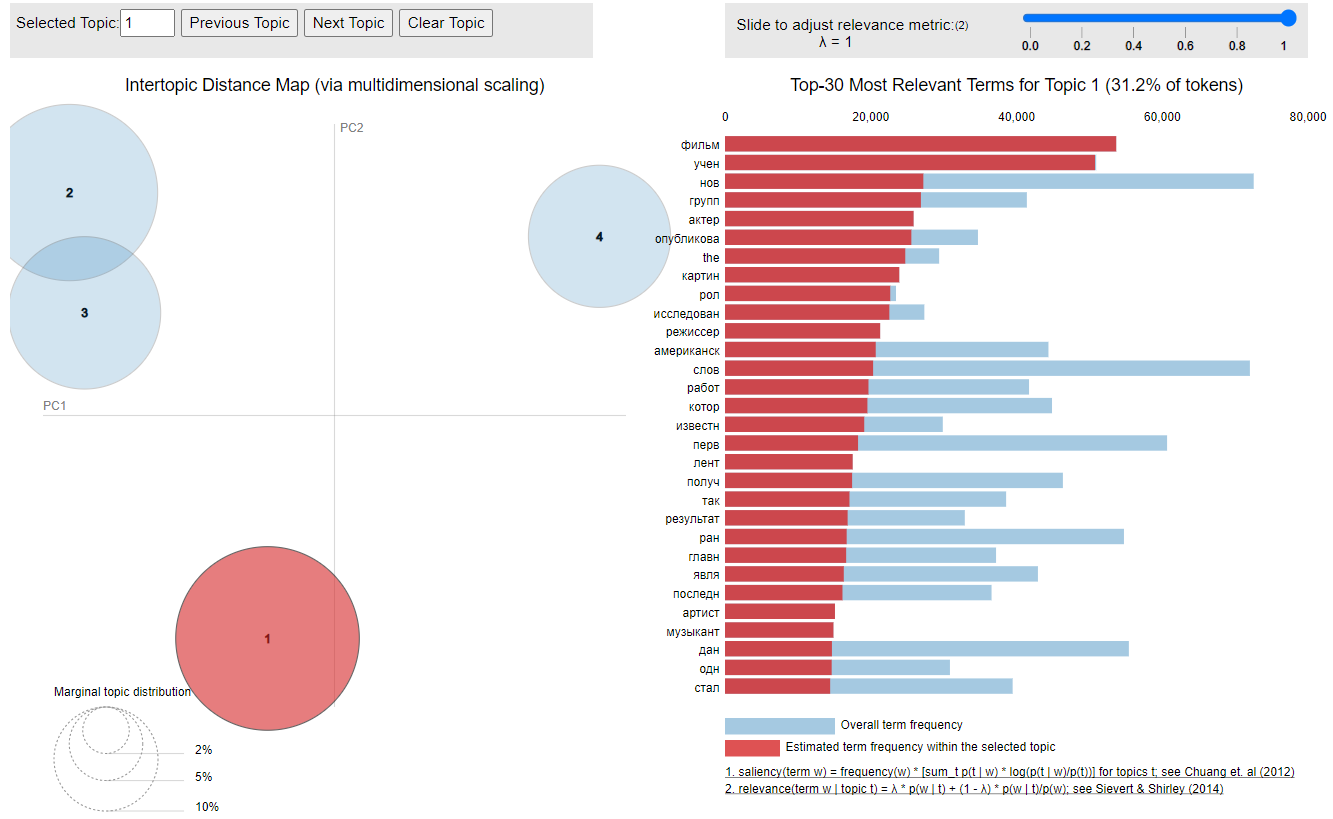

#### Topic 2 - Economy

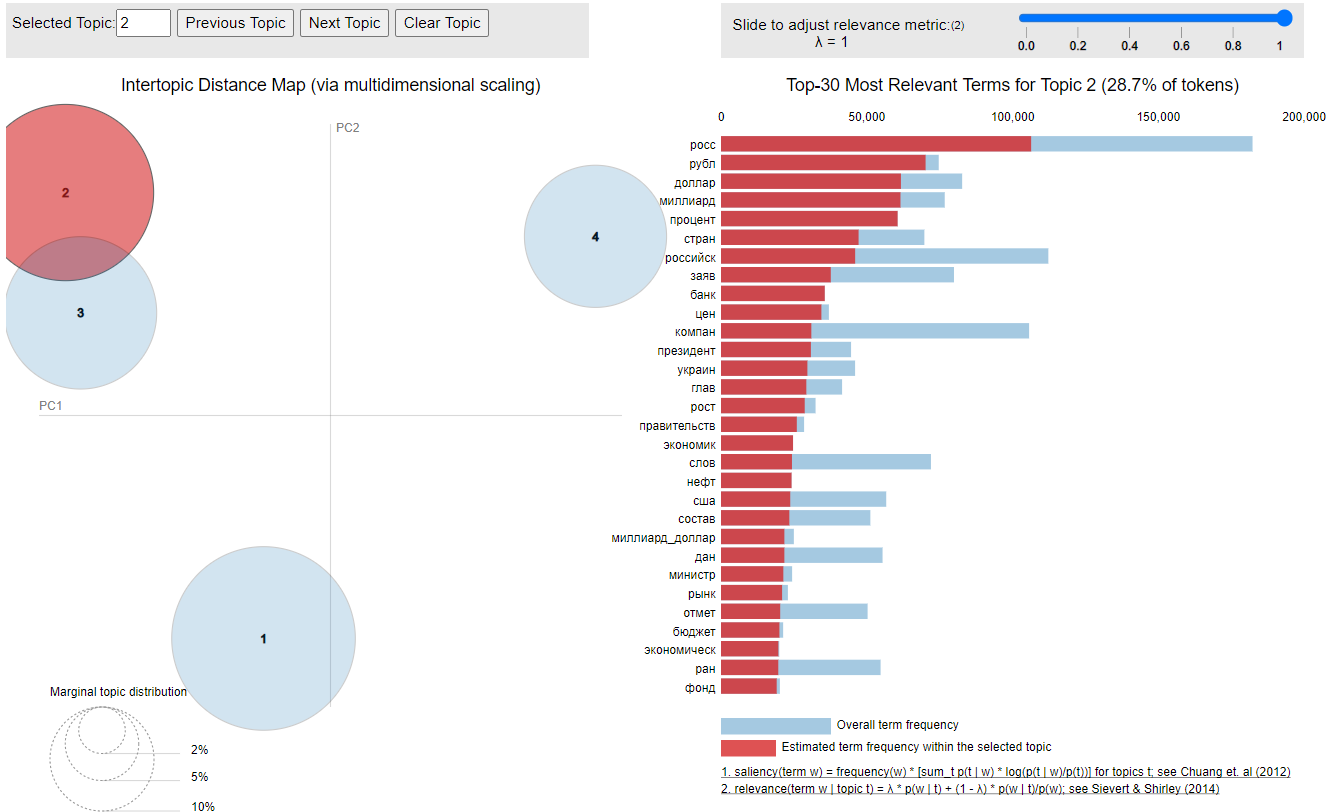

#### Topic 3 - Science and Technology

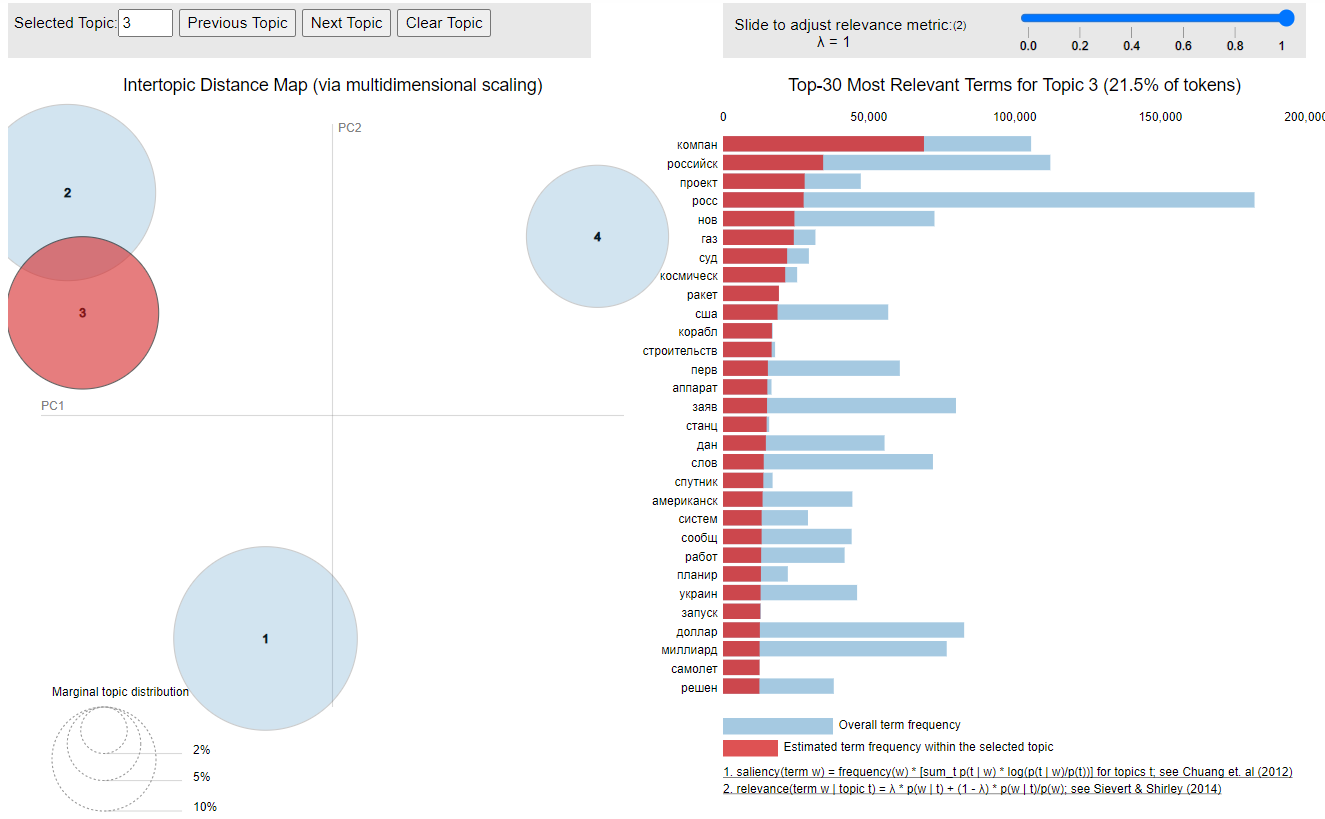

#### Topic 4 - Sport

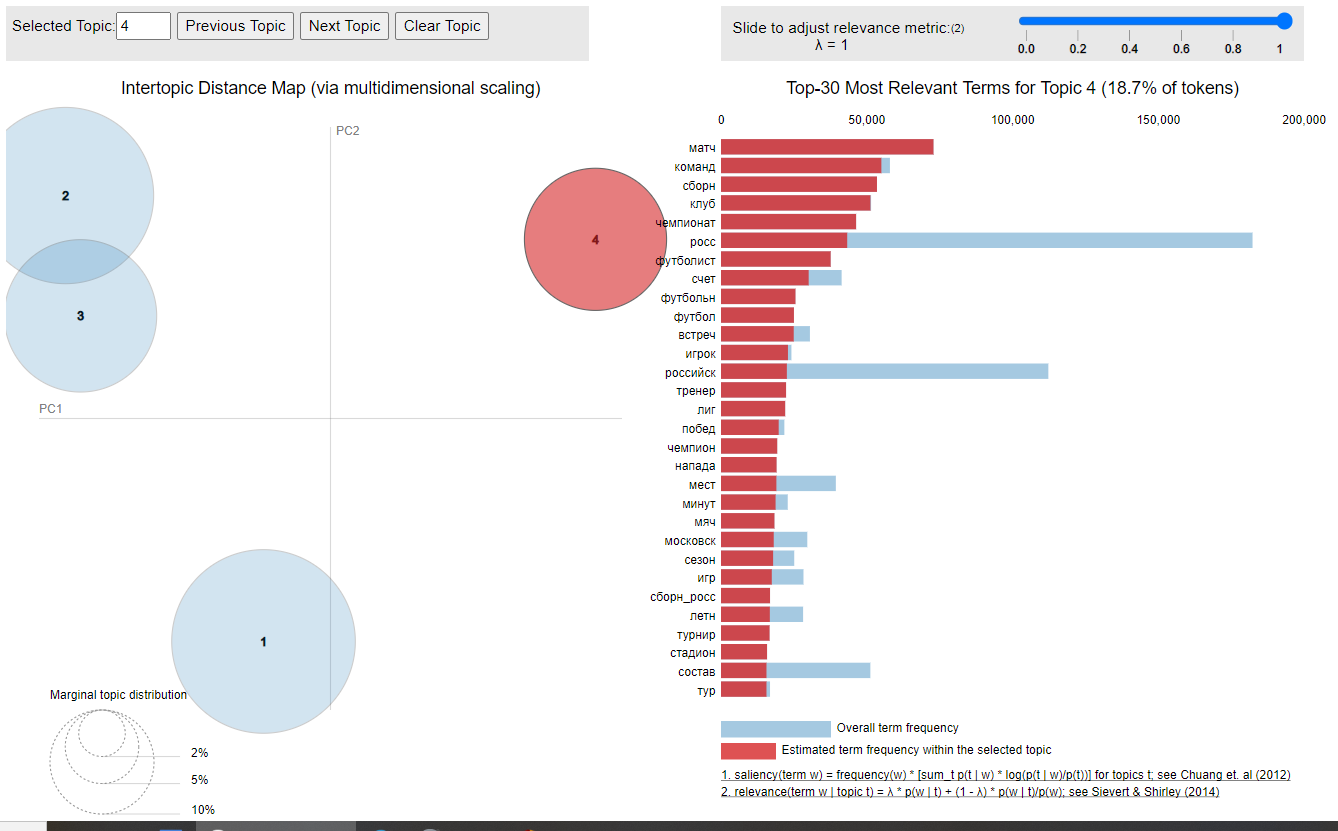